
────────  단계별 요약 (소수점 3자리)  ────────
                               step  count  mean_sec  median_sec  p95_sec  \
step_label                                                                  
Step 1                         입력받기   2512     0.000       0.000    0.000   
Step 2                       ICC 분류   2512     0.651       0.606    0.842   
Step 3                     ICC 분기처리   2512     0.000       0.000    0.001   
Step 4           통합 제안 분리 및 요약 (영어)   2512     1.052       0.933    1.685   
Step 5                    첫번째 제안 선택   2512     0.855       0.792    1.257   
Step 6              Top-10 유사 문서 검색   2512     0.826       0.686    0.829   
Step 7          Self-Consistency 평가   2512     5.243       4.807    7.335   
Step 8          Self-Consistency 파싱   2512     0.000       0.000    0.000   
Step 9      Self-Consistency 테이블 포맷   2512     0.000       0.000    0.000   
Step 10                       최종 결정   2512     3.053       2.197    7.697   

            max_sec  mean_tok  median

<Figure size 1000x400 with 0 Axes>

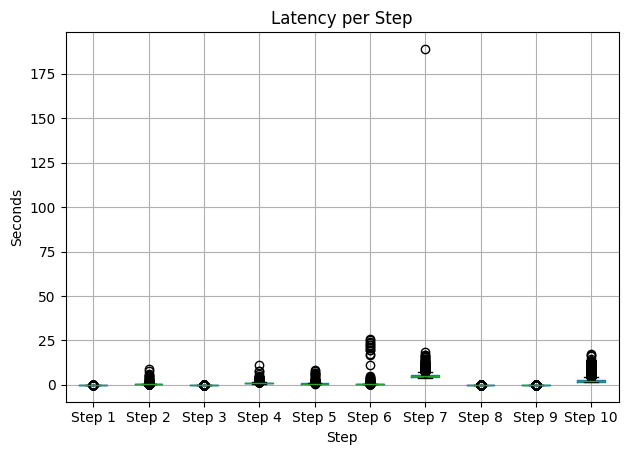

<Figure size 1000x400 with 0 Axes>

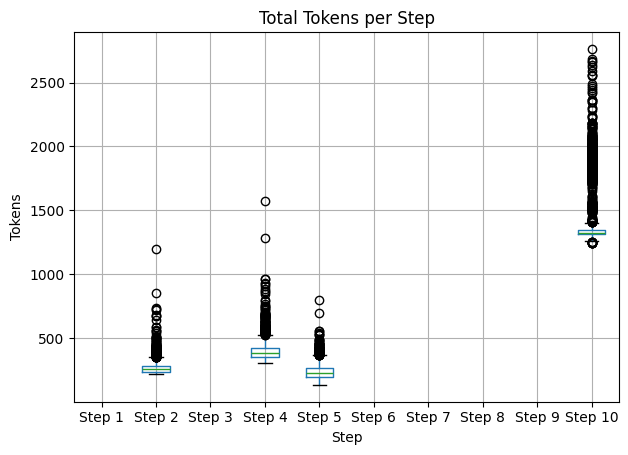

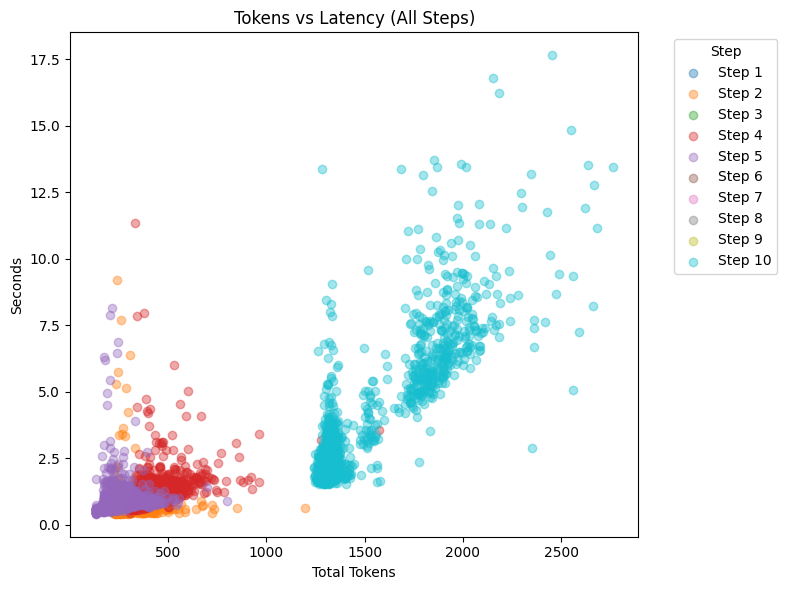

In [3]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# ───────────────── 0. (필요 시) CSV 로드 ─────────────────
# try:
#     df
# except NameError:
#     dfs = [pd.read_csv(f"./result_mini_short_re_{i}.csv") for i in (1, 2, 3)]
#     df = pd.concat(dfs, ignore_index=True)

df = pd.read_csv("./test_result_labeled_v2.csv")

# ───────────────── 1. long‑form 전개 함수 ─────────────────
def explode_timing(d):
    return (
        d[["ticket_id_hashed", "timing_results"]]
          .dropna()
          .assign(timing_results=lambda x: x["timing_results"].apply(ast.literal_eval))
          .explode("timing_results")
          .dropna()
          .assign(step=lambda x: x["timing_results"].str[0],
                  seconds=lambda x: x["timing_results"].str[1].astype(float))
    )

def explode_tokens(d):
    return (
        d[["ticket_id_hashed", "token_usage_results"]]
          .dropna()
          .assign(token_usage_results=lambda x: x["token_usage_results"].apply(ast.literal_eval))
          .explode("token_usage_results")
          .dropna()
          .assign(step=lambda x: x["token_usage_results"].apply(lambda y: y["step"]),
                  total_tokens=lambda x: x["token_usage_results"].apply(lambda y: y["total_tokens"]).astype(float),
                  prompt_tokens=lambda x: x["token_usage_results"].apply(lambda y: y["prompt_tokens"]).astype(float),
                  completion_tokens=lambda x: x["token_usage_results"].apply(lambda y: y["completion_tokens"]).astype(float))
    )

timing_long = explode_timing(df)
token_long  = explode_tokens(df)

# ───────────────── 2. 한글 스텝명을 ASCII 라벨로 매핑 ─────────────────
# ── 0) 분석·시각화 전에 ‘정의역’ 순서부터 확정 ──
step_order = [
    "입력받기",                       # Step 1
    "ICC 분류",                     # Step 2
    "ICC 분기처리",                 # Step 3
    "통합 제안 분리 및 요약 (영어)",   # Step 4
    "첫번째 제안 선택",              # Step 5
    "Top-10 유사 문서 검색",         # Step 6
    "Self-Consistency 평가",         # Step 7
    "Self-Consistency 파싱",         # Step 8
    "Self-Consistency 테이블 포맷",   # Step 9
    "최종 결정",                    # Step 10
]
step_map = {name: f"Step {i+1}" for i, name in enumerate(step_order)}

for tbl in (timing_long, token_long):
    tbl["step_label"] = tbl["step"].map(step_map)

# ───────────────── 3. merge & 파생지표 ─────────────────
merged = pd.merge(
    timing_long[["ticket_id_hashed", "step", "step_label", "seconds"]],
    token_long[["ticket_id_hashed", "step", "total_tokens"]],
    on=["ticket_id_hashed", "step"],
    how="inner",
)
merged["tokens_per_sec"] = merged["total_tokens"] / merged["seconds"]

# ───────────────── 4. summary 계산 ─────────────────
# ───────────────── 4. summary 계산 (수정) ─────────────────
summary = (
    timing_long.groupby("step").agg(
        count=("seconds", "count"),
        mean_sec=("seconds", "mean"),
        median_sec=("seconds", "median"),
        p95_sec=("seconds", lambda s: s.quantile(0.95)),
        max_sec=("seconds", "max"),
    )
    .join(
        token_long.groupby("step").agg(
            mean_tok=("total_tokens", "mean"),
            median_tok=("total_tokens", "median"),
            p95_tok=("total_tokens", lambda s: s.quantile(0.95)),
            max_tok=("total_tokens", "max"),
        )
    )
    .join(
        merged.groupby("step").agg(
            mean_tps=("tokens_per_sec", "mean"),
            p95_tps=("tokens_per_sec", lambda s: s.quantile(0.95)),
        )
    )
    .reset_index()
    .assign(step_label=lambda x: x["step"].map(step_map))
    .set_index("step_label")
    .loc[[f"Step {i+1}" for i in range(len(step_order))]]
)

# 3 자리 반올림
float_cols = summary.select_dtypes(float).columns
summary[float_cols] = summary[float_cols].round(3)

print("\n────────  단계별 요약 (소수점 3자리)  ────────")
print(summary)


# 3 자리 반올림
float_cols = summary.select_dtypes(float).columns
summary[float_cols] = summary[float_cols].round(3)

print("\n────────  단계별 요약 (소수점 3자리)  ────────")
print(summary)

# ───────────────── 5. 시각화 ─────────────────
# ───────────────── 5. 시각화 (1→10 순서 고정) ─────────────────
order_labels = [f"Step {i}" for i in range(1, len(step_order) + 1)]

# 카테고리형으로 순서 고정
for tbl in (timing_long, token_long, merged):
    tbl["step_label"] = pd.Categorical(tbl["step_label"],
                                       categories=order_labels,
                                       ordered=True)

# ① Latency box‑plot
plt.figure(figsize=(10, 4))
timing_long.boxplot(column="seconds", by="step_label")
plt.title("Latency per Step"); plt.suptitle("")
plt.xlabel("Step"); plt.ylabel("Seconds")
plt.tight_layout()

# ② Tokens box‑plot
plt.figure(figsize=(10, 4))
token_long.boxplot(column="total_tokens", by="step_label")
plt.title("Total Tokens per Step"); plt.suptitle("")
plt.xlabel("Step"); plt.ylabel("Tokens")
plt.tight_layout()

# ③ Tokens vs Latency scatter
plt.figure(figsize=(8, 6))
for step in order_labels:
    grp = merged[merged["step_label"] == step]
    plt.scatter(grp["total_tokens"], grp["seconds"], alpha=0.4, label=step)
plt.title("Tokens vs Latency (All Steps)")
plt.xlabel("Total Tokens"); plt.ylabel("Seconds")
plt.legend(title="Step", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.show()

In [4]:
merged

,ticket_id_hashed,step,step_label,seconds,total_tokens,tokens_per_sec
0,b838720,ICC 분류,Step 2,0.985711,231.0,234.348527
1,b838720,통합 제안 분리 및 요약 (영어),Step 4,0.999677,342.0,342.110603
2,b838720,첫번째 제안 선택,Step 5,0.727283,188.0,258.496433
3,b838720,최종 결정,Step 10,2.141000,1271.0,593.647819
4,b839504,ICC 분류,Step 2,0.620085,236.0,380.593275
...,...,...,...,...,...,...
10043,293d3d8,최종 결정,Step 10,1.842508,1323.0,718.043171
10044,775ed0c,ICC 분류,Step 2,0.431420,262.0,607.296710
10045,775ed0c,통합 제안 분리 및 요약 (영어),Step 4,1.713873,417.0,243.308556
10046,775ed0c,첫번째 제안 선택,Step 5,0.761859,290.0,380.648012


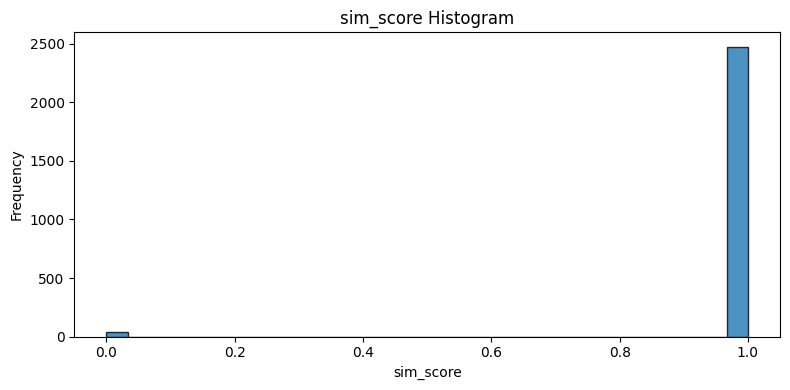

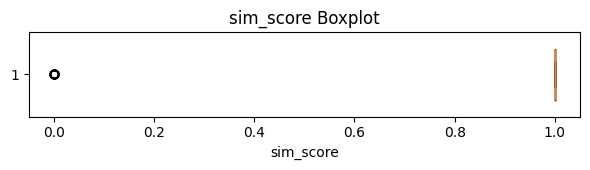

In [5]:
import matplotlib.pyplot as plt

# sim_score Series (0~1 범위 이상치 클립 & NaN 제거)
sim = df["sim_score"].dropna().clip(0, 1)

# ── 히스토그램 ───────────────────────────
plt.figure(figsize=(8, 4))
plt.hist(sim, bins=30, alpha=0.8, edgecolor="black")
plt.title("sim_score Histogram")
plt.xlabel("sim_score")
plt.ylabel("Frequency")
plt.tight_layout()

# ── 박스플롯 ────────────────────────────
plt.figure(figsize=(6, 1.8))
plt.boxplot(sim, vert=False, widths=0.6)
plt.title("sim_score Boxplot")
plt.xlabel("sim_score")
plt.tight_layout()

plt.show()


In [6]:
summary

,step,count,mean_sec,median_sec,p95_sec,max_sec,mean_tok,median_tok,p95_tok,max_tok,mean_tps,p95_tps
step_label,,,,,,,,,,,,
Step 1,입력받기,2512,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN
Step 2,ICC 분류,2512,0.651,0.606,0.842,9.207,269.714,255.0,359.45,1198.0,438.664,622.738
Step 3,ICC 분기처리,2512,0.000,0.000,0.001,0.001,NaN,NaN,NaN,NaN,NaN,NaN
Step 4,통합 제안 분리 및 요약 (영어),2512,1.052,0.933,1.685,11.356,401.939,382.0,535.00,1571.0,406.785,506.645
Step 5,첫번째 제안 선택,2512,0.855,0.792,1.257,8.133,238.375,227.0,341.00,801.0,294.802,417.631
Step 6,Top-10 유사 문서 검색,2512,0.826,0.686,0.829,25.949,NaN,NaN,NaN,NaN,NaN,NaN
Step 7,Self-Consistency 평가,2512,5.243,4.807,7.335,188.822,NaN,NaN,NaN,NaN,NaN,NaN
Step 8,Self-Consistency 파싱,2512,0.000,0.000,0.000,0.001,NaN,NaN,NaN,NaN,NaN,NaN
Step 9,Self-Consistency 테이블 포맷,2512,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
summary.to_csv("./step_summary_mini_short_re.csv", encoding="utf-8-sig")

## 키워드 유사도 전 전처리

In [79]:
import pandas as pd

# dfs = [pd.read_csv(f"./result_short_new_{i}.csv") for i in (1, 2)]
# df = pd.concat(dfs, ignore_index=True)

df = pd.read_csv("./phase2_result_mini_sc1_dup_only.csv")

rag_df = pd.read_csv("./rag_data.csv", usecols=["ticket_id_hashed", "keyword"])

# 기존 df 와 LEFT JOIN
df = df.merge(rag_df, on="ticket_id_hashed", how="left")

print(f"병합 완료: df.shape = {df.shape}")
print(df[["ticket_id_hashed", "keyword"]].head())

병합 완료: df.shape = (206, 20)


KeyError: "['keyword'] not in index"

In [64]:
import re

df["doc_ticket_id"] = (
    df["final_result"]
      .fillna("")                                  # NaN 안전 처리
      .str.extract(r"✅\s*Final Recommended Document:\s*([^\n,]+)", flags=re.I)
      .iloc[:, 0]                                  # capture group 1
      .str.strip()
)

df["doc_ticket_id"] = df["doc_ticket_id"].str.replace(" ", "", regex=False)
df["doc_ticket_id"] = df["doc_ticket_id"].str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
print(df[["final_result", "doc_ticket_id"]].head())

df["doc_summary"] = (
    df["final_result"]
      .fillna("")                                  # NaN 안전 처리
      .str.extract(r"📄\s*Selected Document Summary:\s*([^\n,]+)", flags=re.I)
      .iloc[:, 0]                                  # capture group 1
      .str.strip()
)

# 맨 앞뒤 공백 제거 후, 특수문자 제거
df["doc_summary"] = df["doc_summary"].str.strip()
df["doc_summary"] = df["doc_summary"].str.replace(r"[^0-9a-zA-Z_ ]", "", regex=True)
print(df[["final_result", "doc_summary"]].head())

df.to_csv("./merged_short_new.csv", index=False, encoding="utf-8-sig")

                                        final_result doc_ticket_id
0  > ✅ Final Recommended Document: 8a913b3\n> 📄 S...       8a913b3
1  > ✅ Final Recommended Document: e90e341  \n> 📄...       e90e341
2  > ✅ Final Recommended Document: 94b1567  \n> 📄...       94b1567
3  > ✅ Final Recommended Document: b4e41a3  \n> 📄...       b4e41a3
4  > ✅ Final Recommended Document: 2680acb  \n> 📄...       2680acb
                                        final_result  \
0  > ✅ Final Recommended Document: 8a913b3\n> 📄 S...   
1  > ✅ Final Recommended Document: e90e341  \n> 📄...   
2  > ✅ Final Recommended Document: 94b1567  \n> 📄...   
3  > ✅ Final Recommended Document: b4e41a3  \n> 📄...   
4  > ✅ Final Recommended Document: 2680acb  \n> 📄...   

                                         doc_summary  
0  The user suggests designing a standtype refrig...  
1  The user suggests that the robot vacuum should...  
2  The user suggests that zone cleaning should be...  
3  The user suggests an alert when deterg

In [69]:
import pandas as pd

# ── 1. 파일 로드 ───────────────────────────────────────────
df = pd.read_csv("./merged_short_new.csv")
map_df = pd.read_csv("./rag_data.csv", usecols=["ticket_id_hashed", "keyword"])

# ── 2. ticket_id → keyword 딕셔너리 준비 ───────────────────
id2kw = dict(zip(map_df["ticket_id_hashed"], map_df["keyword"]))

# ── 3. sim_keyword NaN 채우기 ─────────────────────────────
df["sim_keyword"] = df["sim_keyword"].fillna(   # NaN 인 경우에만
    df["doc_ticket_id"].map(id2kw)              # doc_ticket_id → keyword
)

# ── 4. 결과 확인 ───────────────────────────────────────────
print(df[["doc_ticket_id", "sim_keyword"]].head())

  doc_ticket_id  sim_keyword
0       8a913b3  HW디자인개선(외부)
1       e90e341         도면편집
2       94b1567       청소구역설정
3       b4e41a3       알림세부설정
4       2680acb  HW디자인개선(외부)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ticket_id_hashed      2512 non-null   object 
 1   component_group       2512 non-null   object 
 2   components            2512 non-null   object 
 3   beforechange          990 non-null    object 
 4   afterchange           2511 non-null   object 
 5   지역                    2512 non-null   object 
 6   generated_summary     2512 non-null   object 
 7   sim_score             2512 non-null   float64
 8   sim_keyword           2512 non-null   object 
 9   final_keyword         2507 non-null   object 
 10  final_result          2512 non-null   object 
 11  timing_results        2512 non-null   object 
 12  token_usage_results   2512 non-null   object 
 13  proposal_summary_all  2512 non-null   object 
 14  top10_table_md        2512 non-null   object 
 15  labels               

In [9]:
# final_keyword 컬럼 nan 값 예시 보기
# NaN 인 경우만 필터링
nan_rows = df[df["final_keyword"].isna()]

# 몇 건인지 확인
print(f"NaN 행 개수: {len(nan_rows)}")

nan_rows

NaN 행 개수: 5


,ticket_id_hashed,component_group,components,beforechange,afterchange,지역,generated_summary,sim_score,sim_keyword,final_keyword,final_result,timing_results,token_usage_results,proposal_summary_all,top10_table_md,labels,labels_list,label_new
668,69c07bd,세탁기/건조기,세탁기,NaN,세탁물의 무게를 체크해서 세제 양을 추천하거나 셀프조절하는 기능이 탑재되면 좋을 거...,KR,The user suggested that the washing machine sh...,93.55,세탁물무게감지,NaN,> ✅ Final Recommended Document: [fd3d7e1]\n> 📄...,"[('입력받기', 4.76837158203125e-07), ('ICC 분류', 0....","[{'step': 'ICC 분류', 'total_tokens': 253, 'prom...",['The user suggested that the washing machine ...,| 순위 | Ticket ID | Cosine 거리 | 문서 요약 |\n| --- ...,"['24_W43', 'ListA', 'SRM반영', '세제량표시', '세탁기', '...","['24_W43', 'ListA', 'SRM반영', '세제량표시', '세탁기', '...",중복
762,83635ff,세탁기/건조기,세탁기,NaN,세탁기 작동 완료 후 자동 문 열리는 기능 추가 요망,KR,The user suggested adding a feature that autom...,91.60,자동문열림,NaN,> ✅ Final Recommended Document: [1fadacb]\n> 📄...,"[('입력받기', 1.1920928955078125e-06), ('ICC 분류', ...","[{'step': 'ICC 분류', 'total_tokens': 234, 'prom...",['The user suggested adding a feature that aut...,| 순위 | Ticket ID | Cosine 거리 | 문서 요약 |\n| --- ...,"['24_W43', 'ListC', 'UP콘텐츠_종료후세탁물케어', '배포완료', ...","['24_W43', 'ListC', 'UP콘텐츠_종료후세탁물케어', '배포완료', ...",중복
1886,dffb415,공기 청정기,공기청정기,NaN,차일드락 기능 추가해주세요,KR,The user suggested adding a child lock feature...,94.07,잠금기능,NaN,> ✅ Final Recommended Document: [bd82d21]\n> 📄...,"[('입력받기', 9.5367431640625e-07), ('ICC 분류', 0.5...","[{'step': 'ICC 분류', 'total_tokens': 226, 'prom...",['The user suggested adding a child lock featu...,| 순위 | Ticket ID | Cosine 거리 | 문서 요약 |\n| --- ...,"['24_W47', 'ListC', '공기청정기', '기탑재기능', '잠금기능', ...","['24_W47', 'ListC', '공기청정기', '기탑재기능', '잠금기능', ...",중복
2294,af92c4f,미분류,Refrigerator,I’d like the option to turn OFF the door alarm.,도어 알람을 끄는 옵션을 원합니다.,US,The user suggested the option to turn OFF the ...,92.23,문열림알림,NaN,> ✅ Final Recommended Document: [df9f6bc]\n> 📄...,"[('입력받기', 4.76837158203125e-07), ('ICC 분류', 0....","[{'step': 'ICC 분류', 'total_tokens': 231, 'prom...",['The user suggested the option to turn OFF th...,| 순위 | Ticket ID | Cosine 거리 | 문서 요약 |\n| --- ...,"['24_W49', 'ListB', 'Refrigerator', '문열림알림OFF'...","['24_W49', 'ListB', 'Refrigerator', '문열림알림OFF'...",중복
2304,b3b9579,식기세척기,식기세척기,NaN,제가 사용하고 있는 식기세척기 플라스틱 모드를 다운로드코스에 포함시켜주세요,KR,The user suggested to include a plastic mode i...,95.66,UP콘텐츠_플라스틱모드,NaN,> ✅ Final Recommended Document: [b7a9699]\n> 📄...,"[('입력받기', 4.76837158203125e-07), ('ICC 분류', 0....","[{'step': 'ICC 분류', 'total_tokens': 242, 'prom...",['The user suggested to include a plastic mode...,| 순위 | Ticket ID | Cosine 거리 | 문서 요약 |\n| --- ...,"['24_W48', 'ListC', 'UP가전미대상', 'UP콘텐츠_플라스틱모드',...","['24_W48', 'ListC', 'UP가전미대상', 'UP콘텐츠_플라스틱모드',...",중복


In [10]:
# nan_rows 중에서 sim_score가 90이 넘는 경우 sim_keyword를 final_keyword에 대입

nan_rows = nan_rows[nan_rows["sim_score"] > 90]
nan_rows["final_keyword"] = nan_rows["sim_keyword"]

# nan_rows를 다시 df에 병합
df.update(nan_rows[["ticket_id_hashed", "final_keyword"]])

# (선택) 저장
df.to_csv("./test_result_labeled_v2.csv", index=False)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ticket_id_hashed      2512 non-null   object 
 1   component_group       2512 non-null   object 
 2   components            2512 non-null   object 
 3   beforechange          990 non-null    object 
 4   afterchange           2511 non-null   object 
 5   지역                    2512 non-null   object 
 6   generated_summary     2512 non-null   object 
 7   sim_score             2512 non-null   float64
 8   sim_keyword           2512 non-null   object 
 9   final_keyword         2512 non-null   object 
 10  final_result          2512 non-null   object 
 11  timing_results        2512 non-null   object 
 12  token_usage_results   2512 non-null   object 
 13  proposal_summary_all  2512 non-null   object 
 14  top10_table_md        2512 non-null   object 
 15  labels               

## 키워드 유사도 분석

In [12]:
df = pd.read_csv("./test_result_labeled_v2.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ticket_id_hashed      2512 non-null   object 
 1   component_group       2512 non-null   object 
 2   components            2512 non-null   object 
 3   beforechange          990 non-null    object 
 4   afterchange           2511 non-null   object 
 5   지역                    2512 non-null   object 
 6   generated_summary     2512 non-null   object 
 7   sim_score             2512 non-null   float64
 8   sim_keyword           2512 non-null   object 
 9   final_keyword         2512 non-null   object 
 10  final_result          2512 non-null   object 
 11  timing_results        2512 non-null   object 
 12  token_usage_results   2512 non-null   object 
 13  proposal_summary_all  2512 non-null   object 
 14  top10_table_md        2512 non-null   object 
 15  labels               

In [5]:
# ── 0. 라이브러리 설치(필요 시) ─────────────────────────────
# !pip install -q sentence-transformers torch pandas

import pandas as pd
import re
from sentence_transformers import SentenceTransformer, util

# ── 1. 데이터 로드 ───────────────────────────────────────
df = pd.read_csv("./test_result_with_keyword.csv")
df_fil = df[df['label_new'].isin(["신규"])]

# ── 2. 보조 함수 ─────────────────────────────────────────
def extract_selected_summary(text: str) -> str:
    """`📄 Selected Document Summary` 뒤 한 문장 추출"""
    if pd.isna(text):
        return ""
    m = re.search(r'📄\s*Selected Document Summary[:\-]?\s*(.*)',
                  str(text), flags=re.I | re.S)
    if m:
        seg = re.split(r'[\n\r]|✅|🔗|📑|✍️', m.group(1).strip())[0]
        return seg.strip()
    return ""

# summary_text가 없으면 추출
if "summary_text" not in df_fil.columns:
    df_fil["summary_text"] = df_fil["final_result"].apply(extract_selected_summary)

# generated_summary 컬럼 탐색(없으면 doc_summary 사용)
gen_col = next((c for c in df_fil.columns if "generated_summary" in c.lower()),
               None) or next((c for c in df_fil.columns if "doc_summary" in c.lower()), None)

# ── 3. Sentence‑BERT 임베딩 ─────────────────────────────
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def embed(text_iter):
    """
    Pandas Series / list / iterable → torch.Tensor (L, 384)
    Series는 .tolist() 로 변환해 KeyError 방지
    """
    if isinstance(text_iter, pd.Series):
        text_iter = text_iter.astype(str).tolist()
    else:
        text_iter = list(text_iter)
    return model.encode(text_iter,
                        batch_size=64,
                        convert_to_tensor=True,
                        normalize_embeddings=True,
                        show_progress_bar=False)

# ── 4. 키워드 유사도 -------------------------------------------------
kw_mask = df_fil["keyword"].notna() & df_fil["sim_keyword"].notna()
kw_texts     = df_fil.loc[kw_mask, "keyword"].astype(str).tolist()
sim_kw_texts = df_fil.loc[kw_mask, "sim_keyword"].astype(str).tolist()

kw_emb   = embed(kw_texts)
sim_emb  = embed(sim_kw_texts)
df_fil.loc[kw_mask, "sim_keyword_sim"] = (
    util.cos_sim(kw_emb, sim_emb).diagonal().cpu().numpy()
)

# 정확 매칭 여부
df_fil["keyword_match"] = False
df_fil.loc[kw_mask, "keyword_match"] = [
    k.strip().lower() == s.strip().lower()
    for k, s in zip(kw_texts, sim_kw_texts)
]

# (불일치) keyword vs final_keyword
nm_mask = kw_mask & (~df_fil["keyword_match"]) & df_fil["final_keyword"].notna()
kw_nm_emb   = embed(df_fil.loc[nm_mask, "keyword"].astype(str))
final_emb   = embed(df_fil.loc[nm_mask, "final_keyword"].astype(str))
df_fil.loc[nm_mask, "sim_keyword_final"] = (
    util.cos_sim(kw_nm_emb, final_emb).diagonal().cpu().numpy()
)

# ── 5. 요약 관련 유사도 ---------------------------------------------
sum_emb = embed(df_fil["summary_text"].fillna("").astype(str))
aft_emb = embed(df_fil["afterchange"].fillna("").astype(str))
df_fil["sim_summary_after"] = util.cos_sim(sum_emb, aft_emb).diagonal().cpu().numpy()

if gen_col:
    gen_emb = embed(df_fil[gen_col].fillna("").astype(str))
    df_fil["sim_summary_gen"] = util.cos_sim(sum_emb, gen_emb).diagonal().cpu().numpy()

# ── 6. 조건별 통계 요약 ---------------------------------------------
def stats(series):
    s = series.dropna()
    return {
        "count": len(s),
        "mean": round(s.mean(), 3) if len(s) else None,
        "std":  round(s.std(), 3)  if len(s) else None,
        "min":  round(s.min(), 3)  if len(s) else None,
        "25%":  round(s.quantile(0.25), 3) if len(s) else None,
        "50%":  round(s.quantile(0.50), 3) if len(s) else None,
        "75%":  round(s.quantile(0.75), 3) if len(s) else None,
        "max":  round(s.max(), 3)  if len(s) else None,
    }

summary_rows = [
    {"metric": "kw_vs_simkw_all",        **stats(df_fil.loc[kw_mask, "sim_keyword_sim"])},
    {"metric": "kw_vs_simkw_match",      **stats(df_fil.loc[df_fil["keyword_match"], "sim_keyword_sim"])},
    {"metric": "kw_vs_simkw_nomatch",    **stats(df_fil.loc[nm_mask, "sim_keyword_sim"])},
    {"metric": "kw_vs_finalkw_nomatch",  **stats(df_fil.loc[nm_mask, "sim_keyword_final"])},
    {"metric": "summary_vs_after_all",   **stats(df_fil["sim_summary_after"])},
]

if gen_col:
    summary_rows.append({"metric": "summary_vs_gen_all",
                         **stats(df_fil["sim_summary_gen"])})
    summary_rows.append({"metric": "summary_vs_after_matchkw",
                         **stats(df_fil.loc[df_fil["keyword_match"], "sim_summary_after"])})
    summary_rows.append({"metric": "summary_vs_gen_matchkw",
                         **stats(df_fil.loc[df_fil["keyword_match"], "sim_summary_gen"])})

summary_df = pd.DataFrame(summary_rows)

# ── 7. 결과 저장 ------------------------------------------------------
df_fil.to_csv("./test_result_similarity_sentence_v2_new.csv", index=False)
summary_df.to_csv("./similarity_stats_sentenceBERT_new.csv", index=False)

print("✓ 분석 완료 ‑ 결과 파일 두 개가 생성되었습니다.")
print(summary_df)

/var/folders/k4/dp8jpl_52w1g8nsm7nqcr12m0000gn/T/ipykernel_84917/2805563982.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fil["summary_text"] = df_fil["final_result"].apply(extract_selected_summary)
/var/folders/k4/dp8jpl_52w1g8nsm7nqcr12m0000gn/T/ipykernel_84917/2805563982.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fil.loc[kw_mask, "sim_keyword_sim"] = (
/var/folders/k4/dp8jpl_52w1g8nsm7nqcr12m0000gn/T/ipykernel_84917/2805563982.py:62: SettingWithCopyWarning: 
A value is trying to be

✓ 분석 완료 ‑ 결과 파일 두 개가 생성되었습니다.
                     metric  count   mean    std    min    25%    50%    75%  \
0           kw_vs_simkw_all    442  0.652  0.250  0.043  0.498  0.663  0.838   
1         kw_vs_simkw_match     77  1.000  0.000  1.000  1.000  1.000  1.000   
2       kw_vs_simkw_nomatch    365  0.578  0.211  0.043  0.459  0.608  0.726   
3     kw_vs_finalkw_nomatch    365  0.611  0.231  0.018  0.466  0.648  0.765   
4      summary_vs_after_all    442  0.065  0.086 -0.144  0.014  0.055  0.100   
5        summary_vs_gen_all    442  0.614  0.136  0.004  0.533  0.629  0.711   
6  summary_vs_after_matchkw     77  0.055  0.079 -0.144  0.019  0.057  0.090   
7    summary_vs_gen_matchkw     77  0.663  0.140  0.315  0.594  0.680  0.762   

     max  
0  1.000  
1  1.000  
2  1.000  
3  1.000  
4  0.511  
5  0.891  
6  0.445  
7  0.878  


/var/folders/k4/dp8jpl_52w1g8nsm7nqcr12m0000gn/T/ipykernel_84917/2805563982.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fil["sim_summary_gen"] = util.cos_sim(sum_emb, gen_emb).diagonal().cpu().numpy()


In [19]:
summary_df

,metric,count,mean,std,min,25%,50%,75%,max
0,kw_vs_simkw_all,2512,0.755,0.269,0.043,0.564,0.818,1.000,1.000
1,kw_vs_simkw_match,1064,1.000,0.000,1.000,1.000,1.000,1.000,1.000
2,kw_vs_simkw_nomatch,1448,0.574,0.221,0.043,0.397,0.601,0.727,1.000
3,kw_vs_finalkw_nomatch,1448,0.601,0.228,0.018,0.417,0.634,0.758,1.000
4,summary_vs_after_all,2512,0.064,0.085,-0.144,0.013,0.054,0.100,0.710
5,summary_vs_gen_all,2512,0.676,0.158,-0.033,0.603,0.701,0.781,0.995
6,summary_vs_after_matchkw,1064,0.068,0.090,-0.144,0.013,0.055,0.100,0.583
7,summary_vs_gen_matchkw,1064,0.736,0.122,0.250,0.667,0.751,0.823,0.984


In [ ]:
# pip install -q sentence-transformers torch

import pandas as pd
from sentence_transformers import SentenceTransformer, util

# ── 0. 데이터셋 준비 ───────────────────────────────
df = pd.read_csv("./test_result_labeled_v2.csv")
mask = df["keyword"].notna() & df["sim_keyword"].notna()
cmp_df = df.loc[mask, ["keyword", "sim_keyword", "afterchange", "doc_summary", "final_keyword"]].copy()

# ── 1. 임베딩 모델 로드 ────────────────────────────
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")  # 384‑dim

# ── 2. 두 컬럼을 하나로 모아 임베딩 (벡터화는 한 번만!) ───
all_texts = pd.concat([cmp_df["keyword"], cmp_df["sim_keyword"]], ignore_index=True)
embeddings = model.encode(all_texts.tolist(), batch_size=64, convert_to_tensor=True)

# 원본·유사 키워드 순서대로 분리
kw_emb  = embeddings[: len(cmp_df)]
sim_emb = embeddings[len(cmp_df):]

# ── 3. 코사인 유사도 계산 ──────────────────────────
cos_scores = util.cos_sim(kw_emb, sim_emb).diagonal()  # 행 단위 대각선

cmp_df["cosine_sim_bert"] = cos_scores.cpu().numpy()

# ── 4. 정확 일치 & 분포 확인 ───────────────────────
cmp_df["exact_match"] = (
    cmp_df["keyword"].str.strip().str.lower() ==
    cmp_df["sim_keyword"].str.strip().str.lower()
)

exact_ratio = cmp_df["exact_match"].mean()
print(f"정확 일치 비율: {exact_ratio:.3%}")
print("\nBERT 코사인 유사도 통계:\n", cmp_df["cosine_sim_bert"].describe().round(3))

# (선택) top‑k 미스매치 확인
print("\n유사도 낮은 상위 10개:")
print(cmp_df.nsmallest(10, "cosine_sim_bert")[["keyword", "sim_keyword", "cosine_sim_bert"]])

정확 일치 비율: 61.165%

BERT 코사인 유사도 통계:
 count    206.000
mean       0.841
std        0.254
min        0.040
25%        0.744
50%        1.000
75%        1.000
max        1.000
Name: cosine_sim_bert, dtype: float64

유사도 낮은 상위 10개:
            keyword       sim_keyword  cosine_sim_bert
97        건조온도설정/변경       WrinkleCare         0.039804
190           통살균알림         KeepFresh         0.077891
131          최대음량조절      종료알림음볼륨설정/변경         0.078348
87           맞춤청소설정            청소구역설정         0.154010
70         바람방향그림표시         바람세기설정/변경         0.186690
31   HW액세서리/소모품(선반)            정수정량출수         0.187729
116     그룹제어기능변경/추가              온풍예약         0.197452
183          실외온도표시  UP콘텐츠_스마트가이드화면전환         0.201014
136          헹굼탈수코스            헹굼횟수추가         0.246802
156            음원변경             계절별테마         0.251673


In [97]:
len(df)

206

In [98]:
import pandas as pd

# ── 1. 요약 통계 계산 ─────────────────────────────────
total_cnt        = len(cmp_df)
exact_cnt        = cmp_df["exact_match"].sum()
exact_ratio      = exact_cnt / total_cnt
mean_cosine_all  = cmp_df["cosine_sim_bert"].mean()
min_cosine_all   = cmp_df["cosine_sim_bert"].min()

no_match_mask          = ~cmp_df["exact_match"]
mean_cosine_no_match   = cmp_df.loc[no_match_mask, "cosine_sim_bert"].mean()

summary_df = pd.DataFrame(
    [{
        "total_cnt"          : total_cnt,
        "exact_match_cnt"    : exact_cnt,
        "exact_ratio"        : round(exact_ratio, 3),
        "mean_cosine_all"    : round(mean_cosine_all, 3),
        "min_cosine_all"     : round(min_cosine_all, 3),
        "mean_cosine_no_match": round(mean_cosine_no_match, 3),
    }]
)

summary_df

,total_cnt,exact_match_cnt,exact_ratio,mean_cosine_all,min_cosine_all,mean_cosine_no_match
0,206,126,0.612,0.841,0.04,0.59


In [99]:
cmp_df.nsmallest(10, "cosine_sim_bert")[["afterchange", "keyword", "doc_summary", "sim_keyword", "final_keyword", "cosine_sim_bert"]].to_csv("./top10_mismatc_short.csv", index=False, encoding="utf-8-sig")

In [1]:
import pandas as pd

df = pd.read_csv("./test_result.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ticket_id_hashed      2512 non-null   object 
 1   component_group       2512 non-null   object 
 2   components            2512 non-null   object 
 3   beforechange          990 non-null    object 
 4   afterchange           2511 non-null   object 
 5   지역                    2512 non-null   object 
 6   generated_summary     2512 non-null   object 
 7   sim_score             2512 non-null   float64
 8   sim_keyword           2365 non-null   object 
 9   final_keyword         2507 non-null   object 
 10  final_result          2512 non-null   object 
 11  timing_results        2512 non-null   object 
 12  token_usage_results   2512 non-null   object 
 13  proposal_summary_all  2512 non-null   object 
 14  top10_table_md        2512 non-null   object 
dtypes: float64(1), object

In [2]:
2512-2365

147

In [6]:
df = pd.read_csv("./test_result_labeled_v2.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ticket_id_hashed      2512 non-null   object 
 1   component_group       2512 non-null   object 
 2   components            2512 non-null   object 
 3   beforechange          990 non-null    object 
 4   afterchange           2511 non-null   object 
 5   지역                    2512 non-null   object 
 6   generated_summary     2512 non-null   object 
 7   sim_score             2512 non-null   float64
 8   sim_keyword           2512 non-null   object 
 9   final_keyword         2512 non-null   object 
 10  final_result          2512 non-null   object 
 11  timing_results        2512 non-null   object 
 12  token_usage_results   2512 non-null   object 
 13  proposal_summary_all  2512 non-null   object 
 14  top10_table_md        2512 non-null   object 
 15  labels               

/var/folders/k4/dp8jpl_52w1g8nsm7nqcr12m0000gn/T/ipykernel_84917/2691356186.py:40: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/k4/dp8jpl_52w1g8nsm7nqcr12m0000gn/T/ipykernel_84917/2691356186.py:40: UserWarning: Glyph 44508 (\N{HANGUL SYLLABLE GYU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/k4/dp8jpl_52w1g8nsm7nqcr12m0000gn/T/ipykernel_84917/2691356186.py:40: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/k4/dp8jpl_52w1g8nsm7nqcr12m0000gn/T/ipykernel_84917/2691356186.py:40: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/yunho/opt/anaconda3/envs/llm/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yunho/opt/an

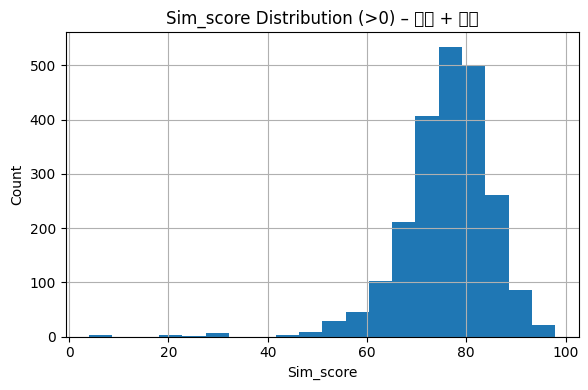


── Threshold별 유사도·일치 통계 ──
 Threshold ≥  Rows  Exact KW Match  KW Match %  Avg KW CosSim  Avg Summary CosSim
          90    62              56       90.32          0.980               0.915
          85   286             226       79.02          0.913               0.851
          80   756             523       69.18          0.876               0.804
          75  1353             786       58.09          0.829               0.761
          70  1791             922       51.48          0.798               0.732

전체 Exact Keyword Match: 1039


In [7]:
# ─────────────────────────────────────────────────────────────────────────────
# requirements:
#   pip install pandas matplotlib sentence-transformers scikit-learn tqdm
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer, util
# from ace_tools import display_dataframe_to_user      # ChatGPT 전용 → 로컬이면 제거 가능
from tqdm import tqdm

# ── 0. 데이터 로드 ────────────────────────────────────────────────────────────
df = pd.read_csv('./test_result_with_keyword.csv', encoding='utf-8-sig')  # 경로 수정

# sim_score 숫자 변환
df['sim_score'] = pd.to_numeric(df['sim_score'], errors='coerce')

# 선택 요약 추출 함수
def extract_selected_summary(text: str) -> str:
    if pd.isna(text): 
        return ""
    m = re.search(r'📄\s*Selected Document Summary[:\-]?\s*(.*)', str(text),
                  flags=re.I | re.S)
    if m:
        seg = re.split(r'[\n\r]|✅|🔗|📑|✍️', m.group(1).strip())[0]
        return seg.strip()
    return ""

# ── 1. 필터링 ────────────────────────────────────────────────────────────────
target_df   = df[df['label_new'].isin(['신규', '중복'])].copy()
non_zero_df = target_df[target_df['sim_score'] > 0].reset_index(drop=True)

# ── 2. 시각화: sim_score 히스토그램 (>0) ───────────────────────────────────────
plt.figure(figsize=(6,4))
non_zero_df['sim_score'].hist(bins=20)
plt.title("Sim_score Distribution (>0) – 신규 + 중복")
plt.xlabel("Sim_score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ── 3. 임베딩 모델 준비 ──────────────────────────────────────────────────────
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")  # 384‑dim

# ── 4. Threshold 분석 ────────────────────────────────────────────────────────
thresholds = [90, 85, 80, 75, 70]
records    = []

for thr in thresholds:
    sub = non_zero_df[non_zero_df['sim_score'] >= thr].copy()
    n   = len(sub)
    
    if n == 0:          # 데이터가 없으면 placeholder
        records.append({
            "Threshold ≥": thr, "Rows": 0,
            "Exact KW Match": 0, "KW Match %": 0,
            "Avg KW CosSim": None, "Avg Summary CosSim": None
        })
        continue

    # ── 4‑1) 키워드 완전 일치 & CosSim ───────────────────────────────────────
    kw_exact = (sub['sim_keyword'].fillna('').str.strip() ==
                sub['keyword'].fillna('').str.strip()).sum()
    
    kw_texts_a = sub['sim_keyword'].astype(str).tolist()
    kw_texts_b = sub['keyword'].astype(str).tolist()
    
    emb_a = model.encode(kw_texts_a, convert_to_tensor=True, show_progress_bar=False)
    emb_b = model.encode(kw_texts_b, convert_to_tensor=True, show_progress_bar=False)
    
    kw_cos = util.cos_sim(emb_a, emb_b).diagonal().cpu().numpy()
    kw_cos_mean = float(np.mean(kw_cos))

    # ── 4‑2) 요약 CosSim ────────────────────────────────────────────────────
    sub['selected_summary'] = sub['final_result'].apply(extract_selected_summary)
    
    sum_texts_a = sub['generated_summary'].astype(str).tolist()
    sum_texts_b = sub['selected_summary'].astype(str).tolist()
    
    if sum_texts_a:     # 리스트가 비어 있지 않을 때만 계산
        emb_g = model.encode(sum_texts_a, convert_to_tensor=True, show_progress_bar=False)
        emb_s = model.encode(sum_texts_b, convert_to_tensor=True, show_progress_bar=False)
        sum_cos = util.cos_sim(emb_g, emb_s).diagonal().cpu().numpy()
        sum_cos_mean = float(np.mean(sum_cos))
    else:
        sum_cos_mean = np.nan

    # ── 4‑3) 결과 집계 ───────────────────────────────────────────────────────
    records.append({
        "Threshold ≥": thr,
        "Rows": n,
        "Exact KW Match": kw_exact,
        "KW Match %": round(kw_exact / n * 100, 2),
        "Avg KW CosSim": round(kw_cos_mean, 3),
        "Avg Summary CosSim": round(sum_cos_mean, 3) if np.isfinite(sum_cos_mean) else None
    })

summary_df = pd.DataFrame(records)

# ChatGPT 환경 아닌 로컬이면 print/CSV 등으로 확인
print("\n── Threshold별 유사도·일치 통계 ──")
print(summary_df.to_string(index=False))

# (ChatGPT 전용) – 데이터프레임 UI 표시
# display_dataframe_to_user("Threshold별 유사도·일치 통계(Keyword)", summary_df)

# ── 5. 전체 Exact Keyword Match ────────────────────────────────────────────
overall_exact = (target_df['sim_keyword'].fillna('').str.strip() ==
                 target_df['keyword'].fillna('').str.strip()).sum()
print(f"\n전체 Exact Keyword Match: {overall_exact}")

/var/folders/k4/dp8jpl_52w1g8nsm7nqcr12m0000gn/T/ipykernel_89030/616018530.py:16: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  plt.xlabel("Sim_score"); plt.ylabel("Count"); plt.tight_layout(); plt.show()
/var/folders/k4/dp8jpl_52w1g8nsm7nqcr12m0000gn/T/ipykernel_89030/616018530.py:16: UserWarning: Glyph 44508 (\N{HANGUL SYLLABLE GYU}) missing from font(s) DejaVu Sans.
  plt.xlabel("Sim_score"); plt.ylabel("Count"); plt.tight_layout(); plt.show()
/var/folders/k4/dp8jpl_52w1g8nsm7nqcr12m0000gn/T/ipykernel_89030/616018530.py:16: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.xlabel("Sim_score"); plt.ylabel("Count"); plt.tight_layout(); plt.show()
/var/folders/k4/dp8jpl_52w1g8nsm7nqcr12m0000gn/T/ipykernel_89030/616018530.py:16: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  plt.xlabel("Sim_score"); plt.ylabel("Count"); plt.tight_layout(); plt.show()
/Users/yunho/op

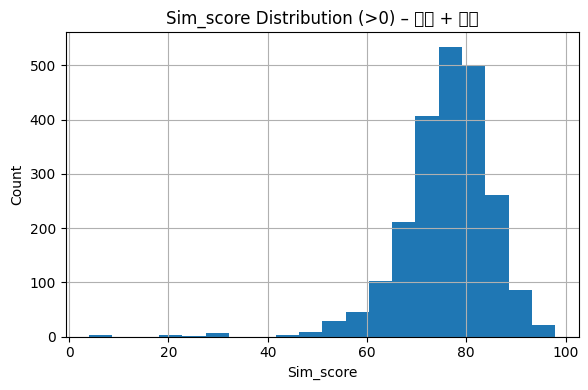

Threshold ≥ 90: 중복+Exact 56 건
Threshold ≥ 85: 중복+Exact 222 건
Threshold ≥ 80: 중복+Exact 503 건
Threshold ≥ 75: 중복+Exact 742 건
Threshold ≥ 70: 중복+Exact 861 건
 Threshold ≥  Rows  Exact KW Match  KW Match %  Avg KW CosSim  Avg Summary CosSim
          90    62              56       90.32          0.980               0.915
          85   286             226       79.02          0.913               0.851
          80   756             523       69.18          0.876               0.804
          75  1353             786       58.09          0.829               0.761
          70  1791             922       51.48          0.798               0.732

전체 Exact Keyword Match (신규+중복, sim_score>0): 1024


In [5]:
import pandas as pd, re, numpy as np, matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util

# ── 0. Load data ────────────────────────────────────────────────────────────
df = pd.read_csv('test_result_with_keyword.csv', encoding='utf-8-sig')
df['sim_score'] = pd.to_numeric(df['sim_score'], errors='coerce')

# ── 1. Filter (신규·중복 + sim_score > 0) ───────────────────────────────────
mask = df['label_new'].isin(['신규', '중복']) & (df['sim_score'] > 0)
sub_df = df[mask].reset_index(drop=True)

# ── 2. Histogram ────────────────────────────────────────────────────────────
plt.figure(figsize=(6,4))
sub_df['sim_score'].hist(bins=20)
plt.title("Sim_score Distribution (>0) – 신규 + 중복")
plt.xlabel("Sim_score"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

# ── 3. ST model ─────────────────────────────────────────────────────────────
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def extract_selected_summary(text: str) -> str:
    if pd.isna(text): return ""
    m = re.search(r'📄\s*Selected Document Summary[:\-]?\s*(.*)', str(text),
                  flags=re.I|re.S)
    if m:
        seg = re.split(r'[\n\r]|✅|🔗|📑|✍️', m.group(1).strip())[0]
        return seg.strip()
    return ""

# ── 4. Threshold loop ───────────────────────────────────────────────────────
thresholds = [90, 85, 80, 75, 70]
results    = []

for thr in thresholds:
    df_thr = sub_df[sub_df['sim_score'] >= thr].copy()
    n      = len(df_thr)
    if n == 0:
        results.append([thr, 0, 0, 0, None, None]); continue

    # 4‑1) Exact keyword match
    kw_exact = (df_thr['sim_keyword'].str.strip()
                == df_thr['keyword'].str.strip()).sum()
    exact_mask       = sub_df['sim_keyword'].str.strip() == sub_df['keyword'].str.strip()
    thr_mask   = sub_df['sim_score'] >= thr
    dup_cnt    = ( exact_mask & thr_mask & (sub_df['label_new']=='중복') ).sum()
    print(f"Threshold ≥ {thr}: 중복+Exact {dup_cnt} 건")
    
    # 4‑2) Keyword cosine similarity
    emb_sim_kw = model.encode(df_thr['sim_keyword'].astype(str).tolist(),
                              convert_to_tensor=True, show_progress_bar=False)
    emb_kw     = model.encode(df_thr['keyword'].astype(str).tolist(),
                              convert_to_tensor=True, show_progress_bar=False)
    kw_cos     = util.cos_sim(emb_sim_kw, emb_kw).diagonal().cpu().numpy().mean()

    # 4‑3) Summary cosine similarity
    df_thr['sel_sum'] = df_thr['final_result'].apply(extract_selected_summary)
    emb_gen_sum = model.encode(df_thr['generated_summary'].astype(str).tolist(),
                               convert_to_tensor=True, show_progress_bar=False)
    emb_sel_sum = model.encode(df_thr['sel_sum'].astype(str).tolist(),
                               convert_to_tensor=True, show_progress_bar=False)
    sum_cos     = util.cos_sim(emb_gen_sum, emb_sel_sum).diagonal().cpu().numpy().mean()

    results.append([thr, n, kw_exact, round(kw_exact/n*100,2),
                    round(kw_cos,3), round(sum_cos,3)])

# ── 5. Display ──────────────────────────────────────────────────────────────
out = pd.DataFrame(results, columns=[
        'Threshold ≥','Rows','Exact KW Match','KW Match %',
        'Avg KW CosSim','Avg Summary CosSim'])
print(out.to_string(index=False))

# ── 6. 전체 Exact match ─────────────────────────────────────────────────────
overall = (sub_df['sim_keyword'].str.strip() ==
           sub_df['keyword'].str.strip()).sum()
print(f"\n전체 Exact Keyword Match (신규+중복, sim_score>0): {overall}")


In [6]:
# ── 4. Threshold loop ───────────────────────────────────────────────────────
thresholds = [90, 85, 80, 75, 70]
results    = []

for thr in thresholds:
    thr_mask = sub_df['sim_score'] >= thr
    df_thr   = sub_df[thr_mask].copy()
    n        = len(df_thr)
    if n == 0:
        results.append([thr, 0, 0, 0,   # Rows, Dup_Total, Dup_Exact
                        0, 0, None, None]); continue

    # ── 4‑1) Exact keyword match
    exact_mask = sub_df['sim_keyword'].str.strip() == sub_df['keyword'].str.strip()
    kw_exact   = (df_thr['sim_keyword'].str.strip() == df_thr['keyword'].str.strip()).sum()

    # ── 중복 행 카운트 (Exact 여부 상관없음)
    dup_total = (thr_mask & (sub_df['label_new'] == '중복')).sum()

    # ── 중복 + Exact 카운트
    dup_exact = (thr_mask & exact_mask & (sub_df['label_new'] == '중복')).sum()

    print(f"Threshold ≥ {thr}:  중복 전체 {dup_total} 건  /  중복+Exact {dup_exact} 건")

    # ── 4‑2) Keyword CosSim
    emb_sim_kw = model.encode(df_thr['sim_keyword'].astype(str).tolist(),
                              convert_to_tensor=True, show_progress_bar=False)
    emb_kw     = model.encode(df_thr['keyword'].astype(str).tolist(),
                              convert_to_tensor=True, show_progress_bar=False)
    kw_cos     = util.cos_sim(emb_sim_kw, emb_kw).diagonal().cpu().numpy().mean()

    # ── 4‑3) Summary CosSim
    df_thr['sel_sum'] = df_thr['final_result'].apply(extract_selected_summary)
    emb_gen_sum = model.encode(df_thr['generated_summary'].astype(str).tolist(),
                               convert_to_tensor=True, show_progress_bar=False)
    emb_sel_sum = model.encode(df_thr['sel_sum'].astype(str).tolist(),
                               convert_to_tensor=True, show_progress_bar=False)
    sum_cos     = util.cos_sim(emb_gen_sum, emb_sel_sum).diagonal().cpu().numpy().mean()

    # 결과 저장
    results.append([thr, n, dup_total, dup_exact,
                    kw_exact, round(kw_exact/n*100,2),
                    round(kw_cos,3), round(sum_cos,3)])

# ── 5. Display ──────────────────────────────────────────────────────────────
out = pd.DataFrame(results, columns=[
        'Threshold ≥','Rows',
        'Dup Total','Dup + Exact',
        'Exact KW Match','KW Match %',
        'Avg KW CosSim','Avg Summary CosSim'])
print(out.to_string(index=False))


Threshold ≥ 90:  중복 전체 62 건  /  중복+Exact 56 건
Threshold ≥ 85:  중복 전체 278 건  /  중복+Exact 222 건
Threshold ≥ 80:  중복 전체 706 건  /  중복+Exact 503 건
Threshold ≥ 75:  중복 전체 1211 건  /  중복+Exact 742 건
Threshold ≥ 70:  중복 전체 1531 건  /  중복+Exact 861 건
 Threshold ≥  Rows  Dup Total  Dup + Exact  Exact KW Match  KW Match %  Avg KW CosSim  Avg Summary CosSim
          90    62         62           56              56       90.32          0.980               0.915
          85   286        278          222             226       79.02          0.913               0.851
          80   756        706          503             523       69.18          0.876               0.804
          75  1353       1211          742             786       58.09          0.829               0.761
          70  1791       1531          861             922       51.48          0.798               0.732
